
1) размечалка + манифест +

2) признаки на основе предыдущих (следующих) строк +

3) countvectorizer по первому второму словам +

4) признак - средний размер баундин бокса +

5) gboost +, xgboost +

6) жирность + (средний цвет ббокса) + средний цвет картинки +

7) кросс-валидация по группам +

8) посмотреть, где ошибается классификатор

In [11]:
import re
import cv2
import json
import numpy as np
from functools import cmp_to_key
from functools import reduce
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, cohen_kappa_score
from xgboost import XGBClassifier

In [12]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1
            re.compile(r'\d\)'), # 1)
            re.compile(r'\w(\.\w)+\W'), # b.b.b
            re.compile(r'[а-яА-Я\d](\.[а-яА-Я\d])+\W'), # б.б.б
            re.compile(r'[a-zA-Z]\)'), # a)
            re.compile(r'[a-zA-Z]\.\W'), # b.
            re.compile(r'[а-яА-Я]\)'), # б)
            re.compile(r'[а-яА-Я]\.\W'), # б.
            re.compile(r'\-'), # -
            re.compile(r'\*'), # *
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья')]

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
                return features
        i += 1
        
    return features

In [13]:
def mean_bbox_size(bboxes):
    """
    bboxes - list [{"text": "", "bbox": []}, {} ...]
    returns (mean_height, mean_width)
    """
    lefts = np.sum(list(map(lambda x: x['bbox'][0], bboxes)))
    widths = np.sum(list(map(lambda x: x['bbox'][2], bboxes)))
    heigths = np.sum(list(map(lambda x: x['bbox'][3], bboxes)))
    num_bboxes = len(bboxes)
    
    return (lefts / num_bboxes, heigths / num_bboxes, widths / num_bboxes)

In [14]:
# add simple font-weight detection

def mean_color(bbox, img):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    avg_color_per_row = np.average(crop_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [15]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features [normalized bbox sizes, normalized mean size of bbox]
        [normalized left, normalized top,
        normalized width, normalized height,
        mean height, mean width]
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            mean_left, mean_heigth, mean_width = mean_bbox_size(doc_info)
            img = cv2.imread('docs/' + doc_name)
            
            avg_color_per_row = np.average(img, axis=0)
            avg_color = np.average((np.average(avg_color_per_row, axis=0)))
            
            heigth = img.shape[0]
            width = img.shape[1]
            for line_info in doc_info:
                line_features = [line_info['bbox'][0] / width,
                                line_info['bbox'][1] / heigth,
                                line_info['bbox'][2] / width,
                                line_info['bbox'][3] / heigth,
                                mean_left, mean_heigth, mean_width,
                                mean_color(line_info['bbox'], img), avg_color]
                line_features += add_reg_features(line_info['text'])
                doc_features.append(line_features)
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [16]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [17]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/

https://xgboost.readthedocs.io/en/latest/tutorials/index.html

In [18]:
def str2num(string):
    if string == "text":
        return 3
    if string == "other":
        return 4
    if string == "list":
        return 2
    return 1

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [str2num(line['label']) for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

In [19]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    GradientBoostingClassifier())

scores = []

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train = reduce(lambda x1, x2: x1 + x2, y[train_index])
    y_test = reduce(lambda x1, x2: x1 + x2, y[test_index])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))

print(scores)
print(np.mean(scores))

[0.7471623651356637, 0.7971720152715331, 0.7691010008494101]
0.7711451270855356


Gradient Boosting 3 folds 0.7896833184157975

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [20]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier())

scores = []

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))

print(scores)
print(np.mean(scores))

[0.8398772119663552, 0.8103215605086755, 0.8062687365220652]
0.818822502999032


XGBoost 3 folds 0.8157148240608598

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [21]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier())

X_train, X_test = X[:400], X[400:]
y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:400]))
y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[400:]))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
score

0.7799976063875363

0.7871247725727105

X_test [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]

In [32]:
d = {}
i = 0
for doc_info in X_test:
    for line_info in doc_info['entities']:
        d[(tuple(line_info['bbox']), doc_info['name'], line_info["text"])] = [y_test[i], y_pred[i]]
        i += 1

KeyboardInterrupt: 

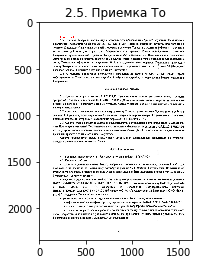

In [46]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

color_dict = {
    1 : (255, 0, 0),
    2 : (0, 255, 0),
    3 : (0, 0, 255),
    4 : (255, 255, 0)
}
class2label = {
    1: "header", 
    2: "list", 
    3: "text", 
    4: "other"
}

for (num, (key, (real_class, predicted_class))) in enumerate(tqdm(d.items())):
    if real_class != predicted_class:
        img = cv2.imread('docs/' + key[1])
        (x, y, w, h) = key[0]
        cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
        cv2.putText(img, class2label[predicted_class] + " " + class2label[real_class], 
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                    color_dict[predicted_class], 2)
        plt.imshow(img)
        plt.title(key[2][:15])
        plt.savefig('different_docs/{}_{}'.format(num, key[1]), dpi=500)
#         .imwrite('different_docs/' + key[1], img)

        

In [50]:
from collections import defaultdict

grouped_by_dock = defaultdict(list)
for item in d.items():
    key, (real_class, predicted_class) = item
    file_name = key[1]
    grouped_by_dock[file_name].append(item)


for file_name, items in tqdm(grouped_by_dock.items()):
    
    img = None 
    for key, (real_class, predicted_class) in items:        
        if real_class != predicted_class:   
            if img is None:
                img = cv2.imread('docs/' + file_name)
            (x, y, w, h) = key[0]
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
            cv2.putText(img, class2label[predicted_class] + " " + class2label[real_class], 
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                        color_dict[predicted_class], 2)
    if img is not None:
        cv2.imwrite('different_docs/' + file_name, img)        